## Deeplearning : Approche 2 Autoencodeurs 

Le but de cet approche est de :
* créer un modèle qui compresse notre donnée d'entrée et réduire drastiquement les dimensions
* Ensuite avec le décodeur de décoder et de reconstituer la donnée d'entrée
* Une fois notre modèle entrainé, les données de test sont classés en fonction de la capacité de reconstitution de la donnée d'entrée (erreur de reconstruction)

In [1]:
# Python libraries:
# to handle datasets
import numpy as np # linear algebra
import random

# Initialization:
np.random.seed(1001)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import time

#import sklearn
#from sklearn import preprocessing
from sklearn.preprocessing import scale

# for sound analysis
import librosa
import librosa.display
import IPython.display as ipd
from scipy import fftpack
from scipy import signal

from tqdm import tqdm_notebook #tqdm

# manage file storage
import feather

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#show pandas version
pd.__version__

'1.3.4'

In [119]:
import keras
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf

from datetime import datetime

from pathlib import Path

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import Activation, UpSampling2D
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization

from tensorflow.keras.losses import MeanSquaredLogarithmicError

from tensorflow.keras.models import load_model, Model, Sequential

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical

# setting random seeds for libraries to ensure reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# visualisations
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

import warnings
warnings.filterwarnings('ignore')

pd.__version__

'1.3.4'

In [291]:
import keras.layers
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.convolutional import Conv2D
from keras.models import Model
from tensorflow.keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
%matplotlib inline
import numpy as np

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D


from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### Génération des data de train et de test

In [2]:
# Paths definition:
# ROOT_AUDIO     = 'DCASE_DATASET' 
ROOT_AUDIO     = '/Users/jsmmvondo/Documents/GitHub/PySaDML/DCASE_DATASET' #Directory name where are all wave files
DEV_DATA_PATH       = os.path.join(ROOT_AUDIO, 'dev_data')
EVAL_DATA_PATH      = os.path.join(ROOT_AUDIO, 'eval_data')

def load_sound_file(audio_path, duration=None):
    """
    Loads a sound file
    
    PARAMS
    ======
        audio_path (string) - location to the WAV file to open
    
    RETURNS
    =======
        signal (numpy array) - sound signal
        sampling_rate (float) - sampling rate detected in the file
    """
    multi_channel_data, sampling_rate = librosa.load(audio_path, sr=None, duration=duration)
    signal = np.array(multi_channel_data)
    
    return signal, sampling_rate

def generate_dataset(data_dir):
    """
    Takes a list for WAV files as an input and generate a numpy array with
    the extracted features.
    
    PARAMS
    ======
        data_dir (string) - Root directory to audio files
        
    RETURNS
    =======
        dataset (dataframe) - dataset
    """

    dataset = []
    filepath = []
    
    #create header variable
    header = 'pathname filename machine_id sample_id audio_format machine_type machine_kind data_split condition durations samplingrate'
#    header += ' chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

#    for i in range(1, 21):
#        header += f' mfcc{i}'

    header = header.split()
    
    for audioroot, _, audiofiles in os.walk(data_dir):
        print(audioroot)
        for index in tqdm_notebook(range(len(audiofiles)), desc='Extracting features'):
            filename = audiofiles[index]
            audiopath = os.path.join(audioroot, filename)
            file_ext = audiopath.split("/")[-1].split("_")[-1].split(".")[-1]
            #print(audiopath)
            if file_ext == 'wav':
                # Load audio file, sr = sample rate, signal = numpy array of audio file
                signal, sr = load_sound_file(audiopath)

                # Extract features from this signal:
                machine_id = audiopath.split("/")[-1].split("_")[2]
                sample_id = audiopath.split("/")[-1].split("_")[-1].split(".")[0]
                audio_format = file_ext
                machine_type = audiopath.split("/")[-3]

                if 'toy' in machine_type:
                    machine_kind = 'toys'
                else:
                    machine_kind = 'real_machine'

                data_split = audiopath.split("/")[-2]
                condition = audiopath.split("/")[-1].split("_")[0]
                durations = len(signal)/sr #librosa.get_duration(filename=audiopath) #len(signal)/sr
                samplingrate = sr #librosa.get_samplerate(audiopath) #sr
                to_append = f'{audiopath} {filename} {machine_id} {sample_id} {audio_format} {machine_type} {machine_kind} {data_split} {condition} {durations} {samplingrate}'    

                #spectral features
    #            chroma_stft = librosa.feature.chroma_stft(y=signal, sr=sr)
    #            rms = librosa.feature.rms(y=signal)
    #            spec_cent = librosa.feature.spectral_centroid(y=signal, sr=sr)
    #            spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=sr)
    #            rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)
    #            zcr = librosa.feature.zero_crossing_rate(signal)
    #            mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    
    #            to_append += f' {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    #            for n in mfcc: # 20 mfcc values so add the relevant value to each column
    #                to_append += f' {np.mean(n)}'

                filepath.append(to_append.split())
            
    dataset = pd.DataFrame(filepath, columns=header)

    return dataset



In [3]:
files = DEV_DATA_PATH
data_location_csv = os.path.join(ROOT_AUDIO, 'dev_data.csv')

if os.path.exists(data_location_csv):
    print('CSV : Train data already exists, loading from file...')
    with open(data_location_csv, 'rb') as f:
         data_csv = pd.read_csv(f, dtype={"machine_id": "str", "sample_id": "str"});
    print('Done.')
        
else:
    data_csv = generate_dataset(files)
    print('Saving csv training data to disk...')
    #with open(data_location_csv, 'wb') as f:
    data_csv.to_csv(data_location_csv);
            
    print('Done.')

CSV : Train data already exists, loading from file...
Done.


In [4]:
data = data_csv.copy()
del data_csv
data.head()

,Unnamed: 0,pathname,filename,machine_id,sample_id,audio_format,machine_type,machine_kind,data_split,condition,durations,samplingrate
0,0,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,anomaly_id_01_00000176.wav,01,00000176,wav,ToyConveyor,real_machine,test,anomaly,10.0,16000
1,1,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,normal_id_03_00000329.wav,03,00000329,wav,ToyConveyor,real_machine,test,normal,10.0,16000
2,2,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,normal_id_01_00000291.wav,01,00000291,wav,ToyConveyor,real_machine,test,normal,10.0,16000
3,3,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,normal_id_01_00000285.wav,01,00000285,wav,ToyConveyor,real_machine,test,normal,10.0,16000
4,4,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,anomaly_id_01_00000162.wav,01,00000162,wav,ToyConveyor,real_machine,test,anomaly,10.0,16000


In [5]:
train_data = data[data['data_split'] == 'train'].reset_index(drop=True)
test_data = data[data['data_split'] == 'test'].reset_index(drop=True)
del data
print(train_data.shape, test_data.shape)

(20119, 12) (10868, 12)


In [6]:
train_data[train_data.isna().any(axis=1)]

,Unnamed: 0,pathname,filename,machine_id,sample_id,audio_format,machine_type,machine_kind,data_split,condition,durations,samplingrate


In [7]:
train_data = train_data.drop(columns = 'Unnamed: 0')
test_data = test_data.drop(columns = 'Unnamed: 0')

### Génération du set de spectogramme mel

In [11]:
def audio_norm(data):
    """
    normalize the data
    
    PARAMS
    ======
        data (array) - audio array

    """
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

def truncAudio(file, min_s):
    """
    truncate the signal to a fixed length 'min_s' in seconds
    
    PARAMS
    ======
        file (string) - location to the WAV file to open
        min_s (float) - fixed length to resize the audio file
        
    RETURNS
    =======
        mel_features (dataframe) - dataset
    """
    
    sig, sr = load_sound_file(file)
    
    sig_len = sig.shape[0]
    min_len = int(sr * min_s)

    if (sig_len > min_len):
        # Truncate the signal to the given length
        sig = sig[:min_len]
    
    return (sig, sr)

def mel_features_extractor(file, min_s, resizeaudio=False):
    """
    Compute a mel-scaled spectrogram and generate a vector from music dataset 
    
    PARAMS
    ======
        file (string) - location to the WAV file to open
        min_s (int) - fixed length in second to resize the audio file
        resizeaudio (boolean) - if True we truncate the audio file to min_ms time
        
    RETURNS
    =======
        mel_features (dataframe) - dataset
    """
    if resizeaudio:
        audio, sample_rate = load_sound_file(file, duration=min_s)
    else:
        audio, sample_rate = load_sound_file(file)
        
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    #mel_features = librosa.power_to_db(mel, ref=np.max)

    return mel

def creat_mel_spectrograms(data_dir, duration=None):
    """
    Takes a list for WAV files as an input and generate a Mel spectrograms image
    
    PARAMS
    ======
        data_dir (string) - Root directory to audio files
        
    """
    
    for audioroot, _, audiofiles in os.walk(data_dir):
        # Parent Directory path
        print(audioroot)
        # Path Spectrogram image
        spectrogram_path = audioroot.replace(ROOT_AUDIO,'spectrogram')
        print(spectrogram_path)
        
        for index in tqdm_notebook(range(len(audiofiles)), desc='Extracting features'):
            filename = audiofiles[index]
            audiopath = os.path.join(audioroot, filename)
            file_ext = audiopath.split("/")[-1].split("_")[-1].split(".")[-1]

            if file_ext == 'wav':
                imagename = filename.replace('.wav','.png')
                # Create the directory
                os.makedirs(spectrogram_path, exist_ok = True)

                # Load audio file, sr = sample rate, signal = numpy array of audio file
                audio, sample_rate = load_sound_file(audiopath, duration=duration)

                # Create spectogram image from this audio signal:
                fig = plt.figure(figsize=[0.72,0.72])
                ax = fig.add_subplot(111)
                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)
                ax.set_frame_on(False)
                
                S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
                                
                image_path = os.path.join(spectrogram_path, imagename)
                plt.savefig(image_path, dpi=100, bbox_inches='tight', pad_inches=0, format='png')
                plt.close('all')

def create_mel_data(data, file, ext, duration=None):
    
    
    file = file+'.'+ext
    mel_data_train_location_ftr = os.path.join(ROOT_AUDIO, file)


    if os.path.exists(mel_data_train_location_ftr):
        print(file + ' already exists, loading from file...')
        #with open(mel_data_train_location_ftr, 'rb') as f:
            #df = pd.read_feather(f, use_threads=True);
        #df.to_csv(mel_data_train_location_ftr)
        df = pd.read_csv(mel_data_train_location_ftr, index_col = 0)
        print('Done.')
            
    else:
       
        print('Saving ' + file + ' to disk...')
        mel_data = data[['pathname','machine_type','machine_kind','condition']]

        
        start = time.process_time()
        mel_data['feature'] = mel_data['pathname'].apply(lambda x : mel_features_extractor(x, duration, resizeaudio=True).flatten())
        end = time.process_time()
        duree = end - start
        print(f'The time to extract the feature from mel spectrogram is : {duree} s' )
        

        featuredf = pd.DataFrame(np.array(mel_data.feature.tolist()))
        featuredf.rename(columns=lambda x : "mel"+str(x), inplace = True)

        df = mel_data.drop('feature', axis=1)
        df = pd.concat([df, featuredf], axis=1)

        #with open(mel_data_train_location_ftr, 'wb') as f:
        df.to_csv(mel_data_train_location_ftr);
            
            
        print('Done.')
        
        del featuredf
        del mel_data
        
    return df

In [9]:
"""
        n_mels (integer) - number of Mel buckets (default: 64)
        n_fft (integer) - length of the windowed signal to compute the short 
                          Fourier transform on
        hop_length (integer) - window increment when computing STFT
        fmin (integer) - low frequency cutoff point that will be used when generating our Mel spectrograms

"""
duration=10
n_mels = 64 #128 #64; The number of Mels refers to the number Mel bands, or “bins”, that our Mel scale will be broken up into
n_fft = 2**13 #=2048 2**10 #2**11 #=2048;  2**13 #=8196; The n_fft length of the discrete Fourier transformation window describes the size of the window that will be used when performing each discrete Fourier transformation across the audio signal
hop_length = 2**11 #=512 n_fft // 2 # 2**9 #=512; describes how much this window is to be shifted along the audio signal during each step of STFT processing
fmin = 20 #The minimum frequency describes the low frequency cutoff point that will be used when generating our Mel spectrograms. We will be using a value of 20 Hz for this parameter since this value represents the bottom of the audible frequency spectrum for most humans.

In [10]:
ext = 'csv'
df_mel_train = create_mel_data(train_data, 'mel_data_train', ext, duration=10)
df_mel_train.head()

mel_data_train.csv already exists, loading from file...
Done.


,pathname,machine_type,machine_kind,condition,mel0,mel1,mel2,mel3,mel4,mel5,...,mel5046,mel5047,mel5048,mel5049,mel5050,mel5051,mel5052,mel5053,mel5054,mel5055
0,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-16.100058,-18.387196,-16.342037,-15.040987,-18.179344,-20.409138,...,-57.169037,-58.932300,-59.280674,-59.510640,-59.902016,-60.954624,-62.403725,-61.273945,-59.459650,-58.531464
1,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-17.024387,-17.996870,-21.330017,-22.661380,-20.094948,-19.902800,...,-57.375908,-57.654663,-57.654556,-57.886215,-56.423195,-56.083584,-57.445175,-58.211220,-59.139843,-58.239640
2,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-15.217779,-16.617624,-17.986835,-18.709558,-19.755434,-22.176926,...,-57.944930,-56.422012,-55.664917,-55.133180,-55.148937,-54.030518,-53.986160,-54.409645,-54.999740,-55.558716
3,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-18.967043,-20.364712,-20.854671,-19.992592,-20.461006,-19.238323,...,-52.697410,-54.669403,-55.252914,-55.038345,-54.504154,-52.970398,-54.568466,-55.767740,-55.701225,-56.610330
4,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-12.771946,-15.064497,-16.028530,-14.903885,-15.482306,-16.008692,...,-59.244762,-58.982270,-59.133034,-59.598083,-59.602690,-57.947388,-54.973503,-54.301180,-54.565620,-54.996910


In [12]:
ext = 'csv'
df_mel_test = create_mel_data(test_data, 'mel_data_test', ext, duration=10)
df_mel_test.head()

mel_data_test.csv already exists, loading from file...
Done.


,pathname,machine_type,machine_kind,condition,mel0,mel1,mel2,mel3,mel4,mel5,...,mel5046,mel5047,mel5048,mel5049,mel5050,mel5051,mel5052,mel5053,mel5054,mel5055
0,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,anomaly,-23.383516,-20.639809,-20.313389,-19.919840,-20.708096,-21.005710,...,-58.287483,-58.875160,-59.718616,-60.044518,-59.241707,-59.647648,-61.364803,-61.216470,-61.277780,-60.499603
1,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-9.716120,-13.840788,-16.189808,-16.143745,-20.798363,-17.417233,...,-57.864384,-55.647170,-51.307960,-50.295303,-50.646072,-50.688620,-50.857357,-50.792200,-50.905914,-50.680363
2,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-11.043976,-13.051968,-12.825278,-11.441542,-13.392862,-18.139688,...,-49.337036,-45.840664,-44.835490,-45.835060,-46.721954,-46.043938,-45.828293,-46.405354,-45.506540,-44.755050
3,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-14.224063,-15.483646,-19.831749,-18.873880,-18.577896,-20.894018,...,-57.052177,-57.192720,-57.348060,-57.202305,-57.442368,-57.323320,-58.389260,-59.217964,-58.471190,-56.793560
4,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,anomaly,-12.548519,-16.282982,-21.708023,-19.428146,-16.607712,-17.457146,...,-59.692936,-58.468052,-58.695305,-60.516490,-60.010902,-58.574123,-58.851357,-61.584087,-61.107944,-60.508068


In [167]:
features = df_mel_train.iloc[:,4:]
target = df_mel_train['machine_type']

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                   test_size = .2)

In [28]:
# On diminue la shape de notre data pour pouvoir faire fonctionner notre AE

X_train_res = X_train.iloc[:,:4096]
X_test_res = X_test.iloc[:,:4096]

from sklearn.preprocessing import StandardScaler, Normalizer

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_res)
X_test_s = scaler.transform(X_test_res)

In [168]:
print(X_train_s.shape)
print(X_test_s.shape)

(16095, 4096)
(4024, 4096)


### 1er Modèle Autoencoder

In [170]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    #decoder
    self.encoder = Sequential([
      layers.Dense(64, activation="relu"),  
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    #decoder
    self.decoder = Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(4096, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder1 = AnomalyDetector()

In [171]:
#Compilation de l'encoder
autoencoder1.compile(optimizer='adam', loss='mse')

In [172]:
from datetime import datetime

start = datetime.now()

history1 = autoencoder1.fit(X_train_s, X_train_s, 
          epochs=100, 
          batch_size=64,
          validation_data=(X_test_s, X_test_s))

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 16095 samples, validate on 4024 samples
Epoch 1/100
16095/16095 [==============================] - 6s 390us/sample - loss: 0.7830 - val_loss: 0.7203
Epoch 2/100
16095/16095 [==============================] - 5s 318us/sample - loss: 0.7031 - val_loss: 0.6961
Epoch 3/100
16095/16095 [==============================] - 5s 317us/sample - loss: 0.6846 - val_loss: 0.6825
Epoch 4/100
16095/16095 [==============================] - 5s 307us/sample - loss: 0.6747 - val_loss: 0.6753
Epoch 5/100
16095/16095 [==============================] - 5s 304us/sample - loss: 0.6697 - val_loss: 0.6716
Epoch 6/100
16095/16095 [==============================] - 5s 300us/sample - loss: 0.6666 - val_loss: 0.6688
Epoch 7/100
16095/16095 [==============================] - 5s 284us/sample - loss: 0.6649 - val_loss: 0.6675
Epoch 8/100
16095/16095 [==============================] - 5s 284us/sample - loss: 0.6637 - val_loss: 0.6668
Epoch 9/100
16095/16095 [==============================] - 5s 324us/sample - lo

16095/16095 [==============================] - 5s 322us/sample - loss: 0.6456 - val_loss: 0.6520
Epoch 76/100
16095/16095 [==============================] - 5s 317us/sample - loss: 0.6456 - val_loss: 0.6520
Epoch 77/100
16095/16095 [==============================] - 5s 311us/sample - loss: 0.6454 - val_loss: 0.6519
Epoch 78/100
16095/16095 [==============================] - 5s 312us/sample - loss: 0.6454 - val_loss: 0.6520
Epoch 79/100
16095/16095 [==============================] - 5s 314us/sample - loss: 0.6452 - val_loss: 0.6518
Epoch 80/100
16095/16095 [==============================] - 6s 359us/sample - loss: 0.6452 - val_loss: 0.6521
Epoch 81/100
16095/16095 [==============================] - 5s 329us/sample - loss: 0.6452 - val_loss: 0.6521
Epoch 82/100
16095/16095 [==============================] - 5s 318us/sample - loss: 0.6451 - val_loss: 0.6518
Epoch 83/100
16095/16095 [==============================] - 5s 332us/sample - loss: 0.6450 - val_loss: 0.6520
Epoch 84/100
16095/1609

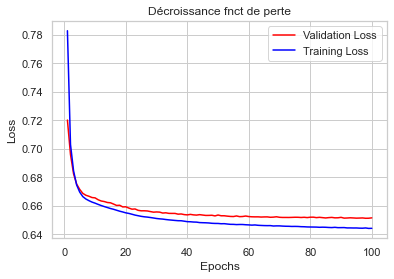

In [173]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 101, 1),
         val_loss,
         label = 'Validation Loss',
         color = 'red')


plt.plot(np.arange(1 , 101, 1),
         train_loss,
         label = 'Training Loss',
         color = 'blue')

# Affichage de la légende
plt.legend()

#Titre
plt.title('Décroissance fnct de perte')

# Affichage de la figure
plt.show()

### Ajout de couches et modifications

In [174]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = Sequential([
      layers.Dense(512, activation="relu"),  
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])

    self.decoder = Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(256, activation="relu"),
      layers.Dense(512, activation="relu"),
      layers.Dense(4096, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder2 = AnomalyDetector()

In [175]:
autoencoder2.compile(optimizer='adam', loss='mse')

In [176]:
from datetime import datetime

start = datetime.now()

history2 = autoencoder2.fit(X_train_s, X_train_s, 
          epochs=100, 
          batch_size=64,
          validation_data=(X_test_s, X_test_s))

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 16095 samples, validate on 4024 samples
Epoch 1/100
16095/16095 [==============================] - 17s 1ms/sample - loss: 0.7483 - val_loss: 0.7013
Epoch 2/100
16095/16095 [==============================] - 17s 1ms/sample - loss: 0.6771 - val_loss: 0.6672
Epoch 3/100
16095/16095 [==============================] - 17s 1ms/sample - loss: 0.6611 - val_loss: 0.6599
Epoch 4/100
16095/16095 [==============================] - 17s 1ms/sample - loss: 0.6554 - val_loss: 0.6568
Epoch 5/100
16095/16095 [==============================] - 18s 1ms/sample - loss: 0.6528 - val_loss: 0.6543
Epoch 6/100
16095/16095 [==============================] - 18s 1ms/sample - loss: 0.6505 - val_loss: 0.6541
Epoch 7/100
16095/16095 [==============================] - 18s 1ms/sample - loss: 0.6491 - val_loss: 0.6507
Epoch 8/100
16095/16095 [==============================] - 18s 1ms/sample - loss: 0.6470 - val_loss: 0.6502
Epoch 9/100
16095/16095 [==============================] - 18s 1ms/sample - loss: 0.645

KeyboardInterrupt: 

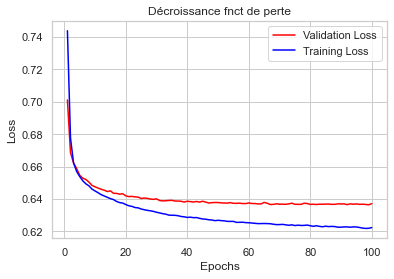

In [138]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 101, 1),
         val_loss,
         label = 'Validation Loss',
         color = 'red')


plt.plot(np.arange(1 , 101, 1),
         train_loss,
         label = 'Training Loss',
         color = 'blue')

# Affichage de la légende
plt.legend()

#Titre
plt.title('Décroissance fnct de perte')

# Affichage de la figure
plt.show()

On constate une amélioration des pertes, maintenant essayons de prévoir les données de test

### Application sur le set de test

In [207]:
feats_test = df_mel_test.iloc[:,4:]
feats_test = feats_test.iloc[:,:4096]
std = StandardScaler()
feats_test_s = scaler.transform(feats_test)

In [208]:
# Evaluation de la reconstruction des données de test
print(autoencoder2.evaluate(x=feats_test_s,y=feats_test_s))

10868/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

1.632062547822011


In [240]:
# prédictions
reconstructions = autoencoder2.predict(feats_test_s)

In [241]:
reconstructions

array([[1.5016168e-02, 1.6108155e-02, 1.7172873e-02, ..., 1.0648370e-04,
        6.1175227e-04, 6.8777800e-04],
       [8.6535072e-01, 8.7396359e-01, 8.5637760e-01, ..., 3.6959392e-01,
        1.8727991e-01, 2.1172294e-01],
       [9.9282634e-01, 9.9280095e-01, 9.9527299e-01, ..., 9.9994367e-01,
        9.9995285e-01, 9.9997467e-01],
       ...,
       [9.1644812e-01, 9.0046626e-01, 8.9828742e-01, ..., 9.9993742e-01,
        9.9995542e-01, 9.9996722e-01],
       [9.9883223e-01, 9.9922204e-01, 9.9926448e-01, ..., 9.9999982e-01,
        9.9999988e-01, 9.9999988e-01],
       [9.9518543e-01, 9.9648392e-01, 9.9656224e-01, ..., 9.9999970e-01,
        9.9999976e-01, 9.9999982e-01]], dtype=float32)

In [243]:
# calcul de la perte 
mse = np.mean(np.power(feats_test_s - reconstructions, 2), axis=1)

In [244]:
mse

array([1.00423722, 0.41203381, 1.0540446 , ..., 2.51005975, 3.54632195,
       3.244131  ])

In [245]:
# Fonction numérisant la colonne condition
def condition(x):
    if x == 'anomaly':
        x = 0
    else:
        x = 1
    return x

In [246]:
#Target
y = df_mel_test['condition'].apply(lambda x: condition(x))

In [299]:
# Fonction fixant le seuil de la perte pour un classement normal ou anormal
def seuil(x):
    if x < 0.7:
        x = 1
    else:
        x = 0
    return x

In [300]:
mse_seuil = []

for i in mse:
    s = seuil(i)
    mse_seuil.append(s)

In [294]:
mse_seuil = pd.Series(mse_seuil)

In [295]:
mse_seuil

0        1
1        1
2        1
3        1
4        1
        ..
10863    0
10864    0
10865    0
10866    0
10867    0
Length: 10868, dtype: int64

In [296]:
pd.crosstab(y, mse_seuil)

col_0,0,1
condition,,
0,3670,1799
1,2139,3260


In [297]:
# Résultats des predictions en fonction des types de machine
pd.crosstab([df_mel_test['machine_type'], df_mel_test['condition']], columns = mse_seuil)

col_0                      0     1
machine_type condition            
ToyCar       anomaly     276   783
             normal      246  1154
ToyConveyor  anomaly     191   919
             normal      348  2051
fan          anomaly    1396    79
             normal      381    19
pump         anomaly     452     4
             normal      382    18
slider       anomaly     885     5
             normal      386    14
valve        anomaly     470     9
             normal      396     4

In [298]:
print(metrics.classification_report(y, mse_seuil))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      5469
           1       0.64      0.60      0.62      5399

    accuracy                           0.64     10868
   macro avg       0.64      0.64      0.64     10868
weighted avg       0.64      0.64      0.64     10868



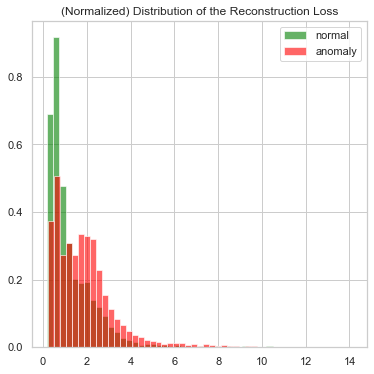

In [248]:
normal = mse[y == 1]
anomaly = mse[y == 0]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal, bins=50, density=True, label="normal", alpha=.6, color="green")
ax.hist(anomaly, bins=50, density=True, label="anomaly", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [ ]:
#Couches avec CNN

In [198]:
model = Sequential()
# encoder network
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (64,64,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
#decoder network
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer
model.compile(optimizer= 'adam', loss = 'mse')
model.summary()



Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 30)        300       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 30)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 15)        4065      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 15)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 15)        2040      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 30)      

In [199]:
X_train_cnn = X_train_s.reshape((-1, 64, 64, 1))

X_test_cnn = X_test_s.reshape((-1, 64, 64, 1))

In [201]:



history3 = model.fit(X_train_cnn, X_train_cnn,
                epochs=20,
                batch_size=500,
                validation_data=(X_test_cnn, X_test_cnn))


Train on 16095 samples, validate on 4024 samples
Epoch 1/20
16095/16095 [==============================] - 352s 22ms/sample - loss: 0.6631 - val_loss: 0.6599
Epoch 2/20
16095/16095 [==============================] - 337s 21ms/sample - loss: 0.6547 - val_loss: 0.6531
Epoch 3/20
16095/16095 [==============================] - 338s 21ms/sample - loss: 0.6496 - val_loss: 0.6496
Epoch 4/20
16095/16095 [==============================] - 335s 21ms/sample - loss: 0.6466 - val_loss: 0.6466
Epoch 5/20
16095/16095 [==============================] - 337s 21ms/sample - loss: 0.6443 - val_loss: 0.6445
Epoch 6/20
16095/16095 [==============================] - 333s 21ms/sample - loss: 0.6425 - val_loss: 0.6426
Epoch 7/20
16095/16095 [==============================] - 331s 21ms/sample - loss: 0.6410 - val_loss: 0.6413
Epoch 8/20
16095/16095 [==============================] - 342s 21ms/sample - loss: 0.6396 - val_loss: 0.6400
Epoch 9/20
16095/16095 [==============================] - 336s 21ms/sample - lo